In [74]:

# !pip install transformers
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np
import pandas as pd
import os
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
# import tensorflow_models as tfm
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from keras.utils import pad_sequences
from keras.utils import to_categorical
import keras
import time
import datetime

pd.set_option("display.max_columns", 30)
pd.set_option("display.width", 500)


In [5]:
traindf = pd.read_csv('train.csv')
traindf

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring
0,423A1CA112E2,1.622628e+12,8.0,229.0,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
1,423A1CA112E2,1.622628e+12,230.0,312.0,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
2,423A1CA112E2,1.622628e+12,313.0,401.0,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
3,423A1CA112E2,1.622628e+12,402.0,758.0,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...
4,423A1CA112E2,1.622628e+12,759.0,886.0,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...
...,...,...,...,...,...,...,...,...
144288,4C471936CD75,1.618153e+12,2234.0,3203.0,if I'm not sure what college I want to attend...,Evidence,Evidence 2,386 387 388 389 390 391 392 393 394 395 396 39...
144289,4C471936CD75,1.618153e+12,3221.0,4509.0,seeking multiple opinions before making a har...,Evidence,Evidence 3,576 577 578 579 580 581 582 583 584 585 586 58...
144290,4C471936CD75,1.618025e+12,4510.0,4570.0,it is better to seek multiple opinions instead...,Position,Position 1,828 829 830 831 832 833 834 835 836 837 838
144291,4C471936CD75,1.618025e+12,4570.0,4922.0,The impact of asking people to help you make a...,Evidence,Evidence 4,839 840 841 842 843 844 845 846 847 848 849 85...


In [6]:
categories = ['Claim', 'Concluding Statement', 'Counterclaim', 'Evidence', 'Lead', 'Position', 'Rebuttal']
traindf['labels'] = traindf.discourse_type.astype('category').cat.codes
traindf


,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring,labels
0,423A1CA112E2,1.622628e+12,8.0,229.0,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...,4
1,423A1CA112E2,1.622628e+12,230.0,312.0,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59,5
2,423A1CA112E2,1.622628e+12,313.0,401.0,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75,3
3,423A1CA112E2,1.622628e+12,402.0,758.0,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...,3
4,423A1CA112E2,1.622628e+12,759.0,886.0,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...,0
...,...,...,...,...,...,...,...,...,...
144288,4C471936CD75,1.618153e+12,2234.0,3203.0,if I'm not sure what college I want to attend...,Evidence,Evidence 2,386 387 388 389 390 391 392 393 394 395 396 39...,3
144289,4C471936CD75,1.618153e+12,3221.0,4509.0,seeking multiple opinions before making a har...,Evidence,Evidence 3,576 577 578 579 580 581 582 583 584 585 586 58...,3
144290,4C471936CD75,1.618025e+12,4510.0,4570.0,it is better to seek multiple opinions instead...,Position,Position 1,828 829 830 831 832 833 834 835 836 837 838,5
144291,4C471936CD75,1.618025e+12,4570.0,4922.0,The impact of asking people to help you make a...,Evidence,Evidence 4,839 840 841 842 843 844 845 846 847 848 849 85...,3


In [156]:
sentences = traindf['discourse_text'].values
labels = traindf['labels'].values


In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  Modern humans today are always on their phone. They are always on their phone more than 5 hours a day no stop .All they do is text back and forward and just have group Chats on social media. They even do it while driving.
Tokenized:  ['modern', 'humans', 'today', 'are', 'always', 'on', 'their', 'phone', '.', 'they', 'are', 'always', 'on', 'their', 'phone', 'more', 'than', '5', 'hours', 'a', 'day', 'no', 'stop', '.', 'all', 'they', 'do', 'is', 'text', 'back', 'and', 'forward', 'and', 'just', 'have', 'group', 'chat', '##s', 'on', 'social', 'media', '.', 'they', 'even', 'do', 'it', 'while', 'driving', '.']
Token IDs:  [2715, 4286, 2651, 2024, 2467, 2006, 2037, 3042, 1012, 2027, 2024, 2467, 2006, 2037, 3042, 2062, 2084, 1019, 2847, 1037, 2154, 2053, 2644, 1012, 2035, 2027, 2079, 2003, 3793, 2067, 1998, 2830, 1998, 2074, 2031, 2177, 11834, 2015, 2006, 2591, 2865, 1012, 2027, 2130, 2079, 2009, 2096, 4439, 1012]


In [28]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in tqdm.tqdm(sentences):
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
        sent,  # Sentence to encode.
        add_special_tokens=True,  # Add '[CLS]' and '[SEP]'

        # This function also supports truncation and conversion
        # to pytorch tensors, but we need to do padding, so we
        # can't use these features :( .
#         max_length=512,          # Truncate all sentences.
#         truncation=True
        # return_tensors = 'pt',     # Return pytorch tensors.
    )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])


100%|█████████████████████████████████████████████████████| 144293/144293 [02:28<00:00, 970.31it/s]

Original:  Modern humans today are always on their phone. They are always on their phone more than 5 hours a day no stop .All they do is text back and forward and just have group Chats on social media. They even do it while driving.
Token IDs: [101, 2715, 4286, 2651, 2024, 2467, 2006, 2037, 3042, 1012, 2027, 2024, 2467, 2006, 2037, 3042, 2062, 2084, 1019, 2847, 1037, 2154, 2053, 2644, 1012, 2035, 2027, 2079, 2003, 3793, 2067, 1998, 2830, 1998, 2074, 2031, 2177, 11834, 2015, 2006, 2591, 2865, 1012, 2027, 2130, 2079, 2009, 2096, 4439, 1012, 102]


In [31]:
sent_len = pd.Series([len(i.split(' ')) for i in traindf['discourse_text']])
print(sent_len.mean())
print(sent_len.median())

44.016937758588426
28.0


c:\users\python\python37\lib\site-packages\ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  


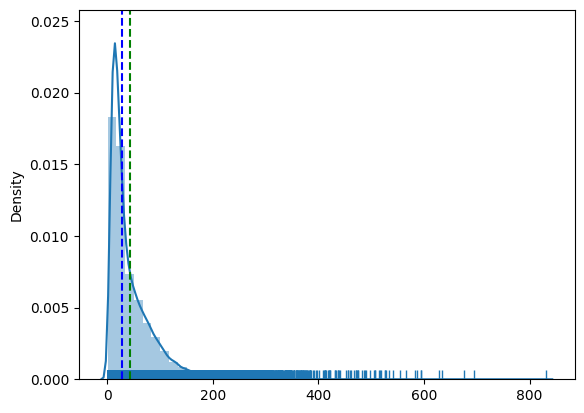

In [33]:
# pd.Series([len(i.split(' ')) for i in traindf['discourse_text']]).hist(bins = 150)
sns.distplot(sent_len, kde=True, rug=True)
plt.axvline(np.median(sent_len),color='b', linestyle='--')
plt.axvline(np.mean(sent_len),color='green', linestyle='--')
# plt.axvline(np.mode(sent_len),color='r', linestyle='--')
plt.show()

In [34]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Max sentence length:  913


In [35]:
# Set the maximum sequence length.
# I've chosen 64 somewhat arbitrarily. It's slightly larger than the
# maximum training sentence length of 47...
MAX_LEN = 50

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long",
                          value=0, truncating="post", padding="post")

print('\nDone.')
print(input_ids[0])


Padding/truncating all sentences to 50 values...

Padding token: "[PAD]", ID: 0

Done.
[  101  2715  4286  2651  2024  2467  2006  2037  3042  1012  2027  2024
  2467  2006  2037  3042  2062  2084  1019  2847  1037  2154  2053  2644
  1012  2035  2027  2079  2003  3793  2067  1998  2830  1998  2074  2031
  2177 11834  2015  2006  2591  2865  1012  2027  2130  2079  2009  2096
  4439  1012]


In [36]:
# Create attention masks
attention_masks = []

# For each sentence...
for sent in tqdm.tqdm(input_ids):
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]

    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)


100%|███████████████████████████████████████████████████| 144293/144293 [00:02<00:00, 49386.47it/s]


In [183]:
# Use train_test_split to split our data into train and validation sets for
# training

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,
                                                            random_state=2018, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.1)

train_labels = to_categorical(list(train_labels))
validation_labels = to_categorical(list(validation_labels))



# train_labels.shape
train_labels

array([[0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

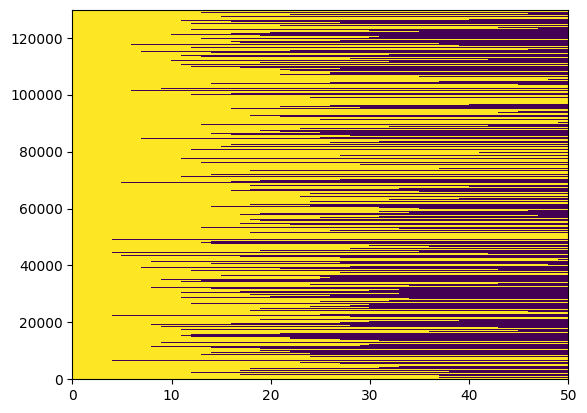

In [55]:
plt.pcolormesh(train_masks)


In [184]:
# Convert all inputs and labels into torch tensors, the required datatype
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [159]:
train = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels, train_masks))
valid = tf.data.Dataset.from_tensor_slices((validation_inputs, validation_labels, validation_masks))

In [185]:
next(iter(train))

(<tf.Tensor: shape=(50,), dtype=int32, numpy=
 array([  101,  1045,  2572,  1999,  5684,  1997,  1996,  6092,  2267,
         2138,  1997,  1996,  3056,  3012,  1997,  9560,  1998,  2022,
        27199,  2063,  1997,  1996,  2163,  1012,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0])>,
 <tf.Tensor: shape=(), dtype=int8, numpy=5>,
 <tf.Tensor: shape=(50,), dtype=int32, numpy=
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0])>)

In [186]:
# #  The DataLoader needs to know our batch size for training, so we specify it
# # here.
# # For fine-tuning BERT on a specific task, the authors recommend a batch size of
# # 16 or 32.

batch_size = 32

# # Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
# # Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [187]:
next(iter(train_dataloader))

[tensor([[  101,  4553,  2129,  ...,     0,     0,     0],
         [  101,  2007,  2715,  ...,  4007,  1012,  2360],
         [  101,  2009,  2003,  ...,  2051,  1012,   102],
         ...,
         [  101,  1996, 23025,  ...,  1012,  1999,  2060],
         [  101,  2062,  5470,  ...,     0,     0,     0],
         [  101,  1045,  5993,  ...,     0,     0,     0]], dtype=torch.int32),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 tensor([[1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 1., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 

In [ ]:
# import json

# bert_config_file = os.path.join("bert_config.json")
# config_dict = {'attention_probs_dropout_prob': 0.1,
#  'hidden_act': 'gelu',
#  'hidden_dropout_prob': 0.1,
#  'hidden_size': 768,
#  'initializer_range': 0.02,
#  'intermediate_size': 3072,
#  'max_position_embeddings': 512,
#  'num_attention_heads': 12,
#  'num_hidden_layers': 12,
#  'type_vocab_size': 2,
#  'vocab_size': 30522}
# config_dict

In [138]:
# from transformers import BertConfig

# config = BertConfig.from_pretrained("bert-base-cased", num_classes=7)

In [ ]:
# from transformers import TFBertForSequenceClassification

# model = TFBertForSequenceClassification(config)
# # config.num_labels = 7
# config

In [135]:
# optimizer = keras.optimizers.Adam(learning_rate=1e-4)
# metrics = [tf.keras.metrics.CategoricalAccuracy('accuracy', dtype=tf.float32)]
# loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

# model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
# model([[train., attention_mask]])

In [ ]:
# model.fit(train, validation_data=valid, epochs=4)

In [152]:
# labels = torch.tensor([1]).unsqueeze(0)
# labels

tensor([[1]])

In [179]:
#  Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 7, # The number of output labels--7for Multi-class classification.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

model

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [180]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [189]:
#  Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr=2e-5,  # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps=1e-8  # args.adam_epsilon  - default is 1e-8.
                  )


c:\users\python\python37\lib\site-packages\transformers\optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [20]:
# Number of training epochs (authors recommend between 2 and 4)
epochs = 1

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


In [21]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [22]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [45]:
next(iter(train_data))

(tensor([  101,  1045,  2572,  1999,  5684,  1997,  1996,  6092,  2267,  2138,
          1997,  1996,  3056,  3012,  1997,  9560,  1998,  2022, 27199,  2063,
          1997,  1996,  2163,  1012,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        dtype=torch.int32),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]),
 tensor([0., 0., 0., 0., 0., 1., 0.]))

In [191]:
import random
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
# torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in tqdm.tqdm(range(0, epochs)):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in tqdm.tqdm(enumerate(train_dataloader)):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0]
        b_input_mask = batch[1]
        b_labels = batch[2]
        

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
#         print(b_input_ids)
#         print(b_labels)
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.numpy()
        label_ids = b_labels.numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")

  0%|                                                                        | 0/4 [00:00<?, ?it/s]
0it [00:00, ?it/s]


======== Epoch 1 / 4 ========
Training...



1it [00:05,  5.11s/it]
2it [00:09,  5.03s/it]
3it [00:14,  4.97s/it]
4it [00:19,  4.93s/it]
5it [00:24,  4.89s/it]
6it [00:29,  4.94s/it]
7it [00:34,  5.03s/it]
8it [00:39,  5.10s/it]
9it [00:45,  5.19s/it]
10it [00:50,  5.19s/it]
11it [00:55,  5.20s/it]
12it [01:00,  5.20s/it]
13it [01:06,  5.22s/it]
14it [01:11,  5.20s/it]
15it [01:16,  5.20s/it]
16it [01:21,  5.21s/it]
17it [01:27,  5.21s/it]
18it [01:32,  5.21s/it]
19it [01:37,  5.24s/it]
20it [01:42,  5.24s/it]
21it [01:48,  5.23s/it]
22it [01:53,  5.24s/it]
23it [01:58,  5.23s/it]
24it [02:03,  5.26s/it]
25it [02:09,  5.26s/it]
26it [02:14,  5.27s/it]
27it [02:19,  5.26s/it]
28it [02:24,  5.27s/it]
29it [02:30,  5.28s/it]
30it [02:35,  5.25s/it]
31it [02:40,  5.23s/it]
32it [02:45,  5.25s/it]
33it [02:51,  5.21s/it]
34it [02:56,  5.22s/it]
35it [03:01,  5.22s/it]
36it [03:06,  5.20s/it]
37it [03:11,  5.22s/it]
38it [03:17,  5.21s/it]
39it [03:22,  5.22s/it]
40it [03:27,  5.22s/it]

  Batch    40  of  4,059.    Elapsed: 0:03:28.



41it [03:32,  5.21s/it]
42it [03:37,  5.22s/it]
43it [03:43,  5.21s/it]
44it [03:48,  5.18s/it]
45it [03:53,  5.20s/it]
46it [03:58,  5.21s/it]
47it [04:04,  5.26s/it]
48it [04:09,  5.35s/it]
49it [04:14,  5.33s/it]
50it [04:20,  5.27s/it]
51it [04:25,  5.25s/it]
52it [04:30,  5.27s/it]
53it [04:36,  5.47s/it]
54it [04:42,  5.56s/it]
55it [04:47,  5.47s/it]
56it [04:52,  5.41s/it]
57it [04:58,  5.37s/it]
58it [05:03,  5.32s/it]
59it [05:08,  5.28s/it]
60it [05:13,  5.27s/it]
61it [05:19,  5.38s/it]
62it [05:24,  5.34s/it]
63it [05:29,  5.29s/it]
64it [05:34,  5.26s/it]
65it [05:40,  5.26s/it]
66it [05:45,  5.23s/it]
67it [05:50,  5.22s/it]
68it [05:55,  5.21s/it]
69it [06:01,  5.20s/it]
70it [06:06,  5.22s/it]
71it [06:11,  5.21s/it]
72it [06:16,  5.20s/it]
73it [06:21,  5.21s/it]
74it [06:27,  5.22s/it]
75it [06:32,  5.22s/it]
76it [06:37,  5.23s/it]
77it [06:42,  5.21s/it]
78it [06:48,  5.23s/it]
79it [06:53,  5.23s/it]
80it [06:58,  5.24s/it]

  Batch    80  of  4,059.    Elapsed: 0:06:59.



81it [07:03,  5.25s/it]
82it [07:08,  5.24s/it]
83it [07:14,  5.20s/it]
84it [07:19,  5.19s/it]
85it [07:24,  5.20s/it]
86it [07:29,  5.18s/it]
87it [07:34,  5.21s/it]
88it [07:40,  5.22s/it]
89it [07:45,  5.24s/it]
90it [07:50,  5.26s/it]
91it [07:56,  5.27s/it]
92it [08:01,  5.25s/it]
93it [08:06,  5.24s/it]
94it [08:11,  5.26s/it]
95it [08:16,  5.25s/it]
96it [08:22,  5.24s/it]
97it [08:27,  5.24s/it]
98it [08:32,  5.22s/it]
99it [08:37,  5.23s/it]
100it [08:43,  5.21s/it]
101it [08:48,  5.20s/it]
102it [08:53,  5.20s/it]
103it [08:58,  5.22s/it]
104it [09:03,  5.25s/it]
105it [09:09,  5.39s/it]
106it [09:15,  5.36s/it]
107it [09:20,  5.33s/it]
108it [09:25,  5.30s/it]
109it [09:30,  5.27s/it]
110it [09:35,  5.26s/it]
111it [09:41,  5.27s/it]
112it [09:46,  5.24s/it]
113it [09:51,  5.23s/it]
114it [09:56,  5.24s/it]
115it [10:02,  5.22s/it]
116it [10:07,  5.21s/it]
117it [10:12,  5.23s/it]
118it [10:17,  5.22s/it]
119it [10:22,  5.23s/it]
120it [10:28,  5.22s/it]

  Batch   120  of  4,059.    Elapsed: 0:10:28.



121it [10:33,  5.20s/it]
122it [10:38,  5.21s/it]
123it [10:43,  5.22s/it]
124it [10:48,  5.22s/it]
125it [10:54,  5.21s/it]
126it [10:59,  5.22s/it]
127it [11:04,  5.23s/it]
128it [11:09,  5.22s/it]
129it [11:15,  5.22s/it]
130it [11:20,  5.20s/it]
131it [11:25,  5.21s/it]
132it [11:30,  5.23s/it]
133it [11:35,  5.23s/it]
134it [11:41,  5.21s/it]
135it [11:46,  5.20s/it]
136it [11:51,  5.21s/it]
137it [11:56,  5.21s/it]
138it [12:01,  5.21s/it]
139it [12:07,  5.20s/it]
140it [12:12,  5.22s/it]
141it [12:17,  5.25s/it]
142it [12:22,  5.22s/it]
143it [12:28,  5.23s/it]
144it [12:33,  5.24s/it]
145it [12:38,  5.23s/it]
146it [12:43,  5.27s/it]
147it [12:49,  5.28s/it]
148it [12:54,  5.26s/it]
149it [12:59,  5.26s/it]
150it [13:05,  5.26s/it]
151it [13:10,  5.23s/it]
152it [13:15,  5.24s/it]
153it [13:20,  5.24s/it]
154it [13:25,  5.23s/it]
155it [13:31,  5.22s/it]
156it [13:36,  5.21s/it]
157it [13:41,  5.18s/it]
158it [13:46,  5.18s/it]
159it [13:51,  5.21s/it]
160it [13:57,  5.20s/it]

  Batch   160  of  4,059.    Elapsed: 0:13:57.



161it [14:02,  5.19s/it]
162it [14:07,  5.17s/it]
163it [14:12,  5.16s/it]
164it [14:17,  5.19s/it]
165it [14:22,  5.21s/it]
166it [14:28,  5.22s/it]
167it [14:33,  5.20s/it]
168it [14:38,  5.19s/it]
169it [14:43,  5.18s/it]
170it [14:48,  5.18s/it]
171it [14:54,  5.18s/it]
172it [14:59,  5.19s/it]
173it [15:04,  5.28s/it]
174it [15:10,  5.42s/it]
175it [15:15,  5.43s/it]
176it [15:21,  5.39s/it]
177it [15:26,  5.38s/it]
178it [15:31,  5.32s/it]
179it [15:37,  5.31s/it]
180it [15:42,  5.27s/it]
181it [15:47,  5.27s/it]
182it [15:52,  5.28s/it]
183it [15:57,  5.25s/it]
184it [16:03,  5.22s/it]
185it [16:08,  5.20s/it]
186it [16:13,  5.17s/it]
187it [16:18,  5.16s/it]
188it [16:23,  5.18s/it]
189it [16:28,  5.20s/it]
190it [16:34,  5.20s/it]
191it [16:39,  5.21s/it]
192it [16:44,  5.19s/it]
193it [16:49,  5.23s/it]
194it [16:55,  5.25s/it]
195it [17:00,  5.27s/it]
196it [17:05,  5.28s/it]
197it [17:10,  5.24s/it]
198it [17:16,  5.26s/it]
199it [17:21,  5.22s/it]
200it [17:26,  5.21s/it]

  Batch   200  of  4,059.    Elapsed: 0:17:27.



201it [17:31,  5.17s/it]
202it [17:36,  5.18s/it]
203it [17:42,  5.23s/it]
204it [17:47,  5.24s/it]
205it [17:52,  5.21s/it]
206it [17:57,  5.23s/it]
207it [18:03,  5.23s/it]
208it [18:08,  5.21s/it]
209it [18:13,  5.22s/it]
210it [18:18,  5.21s/it]
211it [18:23,  5.22s/it]
212it [18:29,  5.21s/it]
213it [18:34,  5.22s/it]
214it [18:39,  5.23s/it]
215it [18:44,  5.23s/it]
216it [18:50,  5.24s/it]
217it [18:55,  5.27s/it]
218it [19:00,  5.27s/it]
219it [19:06,  5.27s/it]
220it [19:11,  5.25s/it]
221it [19:16,  5.21s/it]
222it [19:21,  5.23s/it]
223it [19:26,  5.25s/it]
224it [19:32,  5.26s/it]
225it [19:37,  5.26s/it]
226it [19:42,  5.27s/it]
227it [19:48,  5.41s/it]
228it [19:53,  5.33s/it]
229it [19:58,  5.30s/it]
230it [20:04,  5.29s/it]
231it [20:09,  5.30s/it]
232it [20:14,  5.22s/it]
233it [20:20,  5.36s/it]
234it [20:25,  5.35s/it]
235it [20:30,  5.31s/it]
236it [20:35,  5.25s/it]
237it [20:40,  5.23s/it]
238it [20:46,  5.26s/it]
239it [20:51,  5.26s/it]
240it [20:56,  5.25s/it]

  Batch   240  of  4,059.    Elapsed: 0:20:57.



241it [21:02,  5.25s/it]
242it [21:07,  5.23s/it]
243it [21:12,  5.22s/it]
244it [21:17,  5.25s/it]
245it [21:22,  5.24s/it]
246it [21:28,  5.24s/it]
247it [21:33,  5.23s/it]
248it [21:38,  5.25s/it]
249it [21:43,  5.24s/it]
250it [21:49,  5.23s/it]
251it [21:54,  5.25s/it]
252it [21:59,  5.28s/it]
253it [22:05,  5.28s/it]
254it [22:10,  5.26s/it]
255it [22:15,  5.26s/it]
256it [22:20,  5.27s/it]
257it [22:26,  5.27s/it]
258it [22:31,  5.27s/it]
259it [22:36,  5.26s/it]
260it [22:41,  5.27s/it]
261it [22:47,  5.30s/it]
262it [22:52,  5.28s/it]
263it [22:57,  5.25s/it]
264it [23:02,  5.25s/it]
265it [23:08,  5.21s/it]
266it [23:13,  5.22s/it]
267it [23:18,  5.21s/it]
268it [23:23,  5.21s/it]
269it [23:28,  5.22s/it]
270it [23:34,  5.21s/it]
271it [23:39,  5.21s/it]
272it [23:44,  5.20s/it]
273it [23:49,  5.19s/it]
274it [23:54,  5.18s/it]
275it [24:00,  5.19s/it]
276it [24:05,  5.19s/it]
277it [24:10,  5.19s/it]
278it [24:15,  5.20s/it]
279it [24:20,  5.23s/it]
280it [24:26,  5.24s/it]

  Batch   280  of  4,059.    Elapsed: 0:24:26.



281it [24:31,  5.25s/it]
282it [24:36,  5.25s/it]
283it [24:41,  5.24s/it]
284it [24:47,  5.21s/it]
285it [24:52,  5.20s/it]
286it [24:57,  5.21s/it]
287it [25:02,  5.22s/it]
288it [25:07,  5.20s/it]
289it [25:13,  5.20s/it]
290it [25:18,  5.18s/it]
291it [25:23,  5.17s/it]
292it [25:28,  5.19s/it]
293it [25:33,  5.18s/it]
294it [25:39,  5.20s/it]
295it [25:44,  5.19s/it]
296it [25:49,  5.19s/it]
297it [25:54,  5.22s/it]
298it [25:59,  5.21s/it]
299it [26:05,  5.25s/it]
300it [26:10,  5.22s/it]
301it [26:15,  5.21s/it]
302it [26:20,  5.22s/it]
303it [26:25,  5.20s/it]
304it [26:31,  5.21s/it]
305it [26:36,  5.17s/it]
306it [26:41,  5.19s/it]
307it [26:46,  5.18s/it]
308it [26:51,  5.18s/it]
309it [26:57,  5.21s/it]
310it [27:02,  5.32s/it]
311it [27:08,  5.44s/it]
312it [27:14,  5.60s/it]
313it [27:19,  5.52s/it]
314it [27:24,  5.45s/it]
315it [27:30,  5.38s/it]
316it [27:35,  5.34s/it]
317it [27:40,  5.30s/it]
318it [27:45,  5.29s/it]
319it [27:51,  5.28s/it]
320it [27:56,  5.27s/it]

  Batch   320  of  4,059.    Elapsed: 0:27:56.



321it [28:01,  5.29s/it]
322it [28:06,  5.27s/it]
323it [28:12,  5.28s/it]
324it [28:17,  5.30s/it]
325it [28:22,  5.31s/it]
326it [28:28,  5.31s/it]
327it [28:33,  5.31s/it]
328it [28:38,  5.30s/it]
329it [28:44,  5.30s/it]
330it [28:49,  5.28s/it]
331it [28:54,  5.26s/it]
332it [28:59,  5.27s/it]
333it [29:05,  5.26s/it]
334it [29:10,  5.29s/it]
335it [29:15,  5.31s/it]
336it [29:21,  5.30s/it]
337it [29:26,  5.34s/it]
338it [29:31,  5.31s/it]
339it [29:37,  5.30s/it]
340it [29:42,  5.36s/it]
341it [29:48,  5.38s/it]
342it [29:53,  5.36s/it]
343it [29:58,  5.36s/it]
344it [30:04,  5.48s/it]
345it [30:10,  5.51s/it]
346it [30:15,  5.44s/it]
347it [30:20,  5.45s/it]
348it [30:26,  5.41s/it]
349it [30:31,  5.36s/it]
350it [30:36,  5.36s/it]
351it [30:42,  5.34s/it]
352it [30:47,  5.30s/it]
353it [30:52,  5.29s/it]
354it [30:57,  5.29s/it]
355it [31:03,  5.27s/it]
356it [31:08,  5.24s/it]
357it [31:13,  5.25s/it]
358it [31:18,  5.30s/it]
359it [31:24,  5.32s/it]
360it [31:29,  5.33s/it]

  Batch   360  of  4,059.    Elapsed: 0:31:30.



361it [31:35,  5.42s/it]
362it [31:40,  5.43s/it]
363it [31:45,  5.39s/it]
364it [31:51,  5.43s/it]
365it [31:56,  5.39s/it]
366it [32:02,  5.34s/it]
367it [32:07,  5.32s/it]
368it [32:12,  5.31s/it]
369it [32:17,  5.29s/it]
370it [32:23,  5.31s/it]
371it [32:28,  5.29s/it]
372it [32:33,  5.31s/it]
373it [32:39,  5.33s/it]
374it [32:44,  5.33s/it]
375it [32:49,  5.30s/it]
376it [32:55,  5.31s/it]
377it [33:00,  5.38s/it]
378it [33:05,  5.33s/it]
379it [33:11,  5.33s/it]
380it [33:16,  5.30s/it]
381it [33:21,  5.32s/it]
382it [33:27,  5.33s/it]
383it [33:32,  5.31s/it]
384it [33:37,  5.29s/it]
385it [33:42,  5.27s/it]
386it [33:48,  5.27s/it]
387it [33:53,  5.23s/it]
388it [33:58,  5.22s/it]
389it [34:03,  5.22s/it]
390it [34:09,  5.32s/it]
391it [34:14,  5.30s/it]
392it [34:19,  5.28s/it]
393it [34:24,  5.27s/it]
394it [34:30,  5.24s/it]
395it [34:35,  5.25s/it]
396it [34:40,  5.31s/it]
397it [34:46,  5.33s/it]
398it [34:51,  5.36s/it]
399it [34:57,  5.37s/it]
400it [35:02,  5.41s/it]

  Batch   400  of  4,059.    Elapsed: 0:35:03.



401it [35:07,  5.35s/it]
402it [35:12,  5.31s/it]
403it [35:19,  5.53s/it]
404it [35:24,  5.51s/it]
405it [35:29,  5.44s/it]
406it [35:35,  5.38s/it]
407it [35:40,  5.36s/it]
408it [35:45,  5.32s/it]
409it [35:50,  5.32s/it]
410it [35:56,  5.34s/it]
411it [36:01,  5.37s/it]
412it [36:07,  5.41s/it]
413it [36:12,  5.41s/it]
414it [36:18,  5.43s/it]
415it [36:23,  5.38s/it]
416it [36:28,  5.33s/it]
417it [36:33,  5.34s/it]
418it [36:39,  5.40s/it]
419it [36:45,  5.46s/it]
420it [36:50,  5.45s/it]
421it [36:55,  5.40s/it]
422it [37:01,  5.36s/it]
423it [37:06,  5.32s/it]
424it [37:11,  5.29s/it]
425it [37:16,  5.25s/it]
426it [37:21,  5.25s/it]
427it [37:27,  5.26s/it]
428it [37:32,  5.25s/it]
429it [37:37,  5.24s/it]
430it [37:42,  5.23s/it]
431it [37:48,  5.22s/it]
432it [37:53,  5.23s/it]
433it [37:58,  5.23s/it]
434it [38:03,  5.26s/it]
435it [38:09,  5.26s/it]
436it [38:14,  5.25s/it]
437it [38:19,  5.26s/it]
438it [38:24,  5.24s/it]
439it [38:29,  5.22s/it]
440it [38:35,  5.22s/it]

  Batch   440  of  4,059.    Elapsed: 0:38:35.



441it [38:40,  5.24s/it]
442it [38:45,  5.31s/it]
443it [38:51,  5.29s/it]
444it [38:56,  5.27s/it]
445it [39:01,  5.26s/it]
446it [39:07,  5.28s/it]
447it [39:12,  5.29s/it]
448it [39:17,  5.28s/it]
449it [39:22,  5.26s/it]
450it [39:28,  5.29s/it]
451it [39:33,  5.26s/it]
452it [39:38,  5.26s/it]
453it [39:43,  5.27s/it]
454it [39:49,  5.25s/it]
455it [39:54,  5.27s/it]
456it [39:59,  5.27s/it]
457it [40:04,  5.27s/it]
458it [40:10,  5.25s/it]
459it [40:15,  5.23s/it]
460it [40:20,  5.26s/it]
461it [40:25,  5.22s/it]
462it [40:31,  5.27s/it]
463it [40:36,  5.28s/it]
464it [40:41,  5.30s/it]
465it [40:47,  5.30s/it]
466it [40:52,  5.26s/it]
467it [40:57,  5.24s/it]
468it [41:02,  5.24s/it]
469it [41:07,  5.23s/it]
470it [41:13,  5.23s/it]
471it [41:18,  5.22s/it]
472it [41:23,  5.21s/it]
473it [41:28,  5.23s/it]
474it [41:34,  5.23s/it]
475it [41:39,  5.24s/it]
476it [41:44,  5.26s/it]
477it [41:49,  5.24s/it]
478it [41:55,  5.22s/it]
479it [42:00,  5.24s/it]
480it [42:05,  5.23s/it]

  Batch   480  of  4,059.    Elapsed: 0:42:06.



481it [42:10,  5.23s/it]
482it [42:15,  5.23s/it]
483it [42:21,  5.20s/it]
484it [42:26,  5.21s/it]
485it [42:31,  5.21s/it]
486it [42:36,  5.22s/it]
487it [42:42,  5.26s/it]
488it [42:47,  5.30s/it]
489it [42:52,  5.28s/it]
490it [42:57,  5.27s/it]
491it [43:03,  5.28s/it]
492it [43:08,  5.25s/it]
493it [43:13,  5.24s/it]
494it [43:18,  5.22s/it]
495it [43:24,  5.25s/it]
496it [43:29,  5.26s/it]
497it [43:35,  5.34s/it]
498it [43:40,  5.35s/it]
499it [43:45,  5.32s/it]
500it [43:50,  5.29s/it]
501it [43:56,  5.26s/it]
502it [44:01,  5.26s/it]
503it [44:06,  5.24s/it]
504it [44:12,  5.35s/it]
505it [44:17,  5.33s/it]
506it [44:22,  5.34s/it]
507it [44:28,  5.40s/it]
508it [44:33,  5.38s/it]
509it [44:38,  5.35s/it]
510it [44:44,  5.36s/it]
511it [44:49,  5.35s/it]
512it [44:54,  5.35s/it]
513it [45:00,  5.36s/it]
514it [45:05,  5.37s/it]
515it [45:11,  5.37s/it]
516it [45:16,  5.42s/it]
517it [45:21,  5.39s/it]
518it [45:27,  5.39s/it]
519it [45:32,  5.36s/it]
520it [45:37,  5.33s/it]

  Batch   520  of  4,059.    Elapsed: 0:45:38.



521it [45:43,  5.29s/it]
522it [45:48,  5.25s/it]
523it [45:53,  5.26s/it]
524it [45:58,  5.24s/it]
525it [46:04,  5.26s/it]
526it [46:09,  5.30s/it]
527it [46:14,  5.26s/it]
528it [46:19,  5.26s/it]
529it [46:25,  5.27s/it]
530it [46:30,  5.32s/it]
531it [46:35,  5.34s/it]
532it [46:41,  5.31s/it]
533it [46:46,  5.37s/it]
534it [46:51,  5.33s/it]
535it [46:57,  5.35s/it]
536it [47:02,  5.31s/it]
537it [47:07,  5.26s/it]
538it [47:12,  5.26s/it]
539it [47:18,  5.29s/it]
540it [47:23,  5.28s/it]
541it [47:28,  5.29s/it]
542it [47:34,  5.31s/it]
543it [47:39,  5.34s/it]
544it [47:45,  5.38s/it]
545it [47:50,  5.35s/it]
546it [47:55,  5.36s/it]
547it [48:01,  5.39s/it]
548it [48:06,  5.39s/it]
549it [48:11,  5.36s/it]
550it [48:17,  5.34s/it]
551it [48:22,  5.36s/it]
552it [48:27,  5.35s/it]
553it [48:33,  5.34s/it]
554it [48:38,  5.31s/it]
555it [48:43,  5.32s/it]
556it [48:49,  5.32s/it]
557it [48:56,  5.27s/it]
  0%|                                                                     

KeyboardInterrupt: 

In [192]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')